In [1]:
#import modules
%run ../load_main.py
from Air_Quality_notebooks import utils as utl
from WRFChemToolkit.analysis import statistics as st

## Get model Delhi data

In [2]:
# laod otuputs
post=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/delhiNCT/outputs_postmon/pblmincoeff_tests/wrfout_d01_2019-10-*_00:00:00_nest_2019_newdyno_exchmin5.nc')
post_all=xr.open_mfdataset('/exports/geos.ed.ac.uk/palmer_group/managed/s1878599/delhiAQ/futureEVs/base_runs/postmon/wrfout_d01_2019-10-01_00:00:00_nest_postmon_2019_base.nc')

In [3]:
#season
season='postmonsoon'

In [4]:
#put data in dictionary
s={'post':post, 'post_all':post_all}

In [5]:
def reset_time_dim(ds):
    """
    Time dimension in WRF-Chem datasets is just the time index [0,1,2,3...].
    This function convert dimension Time as datetime[64].
    :param ds:
     wrf-chem xarray dataset.
    :type ds:xarray.Dataset.
    :return:
     xarray.Dataset with datetime time dim.
    :rtype: xarray.Dataset.
    """
    return ds.assign_coords(Time=pd.to_datetime(ds.XTIME.values))

In [6]:
# reset time and discard 5 days  spinup period.
s['post']=reset_time_dim(s['post']).sel(Time=slice('2019-10-06T00:00:00.000000000','2019-10-16T00:00:00.000000000')) # 5 days
s['post_all']=reset_time_dim(s['post_all']).sel(Time=slice('2019-10-01T00:00:00.000000000','2019-10-31T00:00:00.000000000'))  

In [7]:
# subset surface values of relevant pollutants.

In [8]:
# define function to get pollutants and variables of interest.
def get_pollutants(ds):
    
    data ={ 
           "pm25" : (['time',"lat","lon"], ds.PM2_5_DRY.values[:,0,:,:]),           
          }
    coords={'time': (['time'], ds.XTIME[:]),'lat': (['lat'], ds.XLAT[0,:,0]), 'lon': (['lon'], ds.XLONG[0,0,:])}
    p = xr.Dataset(data, coords=coords)
    return p

In [9]:
# get selected pollutants in a dictionary by season
mod={}
for k,v in s.items():
    mod.update({k:get_pollutants(v)})

In [10]:
# extract Delhi NCT data only using shapefile
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st
import salem
s_nct={}
shp = '../gadm_data/delhiNCT/delhiNCT.shp'
for k,v in mod.items():
    s_nct[k]= mod[k].salem.roi(shape=shp)

In [11]:
(s_nct['post_all'].pm25.values[~np.isnan(s_nct['post_all'].pm25.values)]).shape

(67053,)

# Get observations over Delhi

In [12]:
# load observations data
pth ='../observations/cpcb_oct2019_cleaned.xlsx'  # new downloaded direclty from CPCB website.
data=pd.read_excel(pth)

In [13]:
# add utc time to observations
from datetime import timedelta
data['date_UTC'] = pd.to_datetime(data['date_UTC'], format='%Y-%m-%d %H:%M:%S')

In [14]:
# match dataset up to 31/10

In [15]:
data=data[data['date_UTC']<='2019-10-31 00:00:00']

In [16]:
# timeseries avg over Delhi

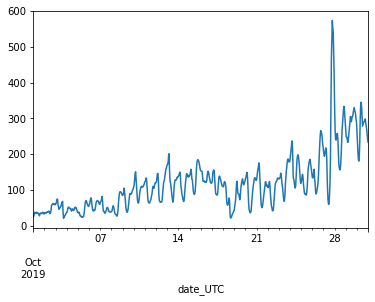

In [17]:
data.groupby('date_UTC').pm25.mean().plot()

In [18]:
# remove diwali infuelnce: Sun 27 OCt 2019

In [19]:
t=data[~data['day_UTC'].isin([27])]

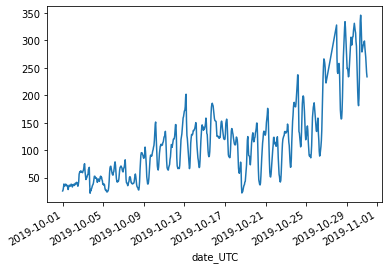

In [20]:
t.groupby('date_UTC').pm25.mean().plot()

In [21]:
# box plot 

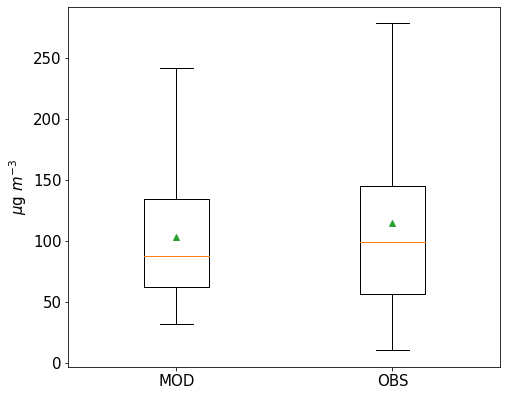

In [22]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
  
# Creating dataset
np.random.seed(10)
 
mod_10d = (s_nct['post'].pm25.values[~np.isnan(s_nct['post'].pm25.values)])
mod_10d=mod_10d[mod_10d!=0]

mod_oct = (s_nct['post_all'].pm25.values[~np.isnan(s_nct['post_all'].pm25.values)])
mod_oct=mod_oct[mod_oct!=0]

obs = t['pm25'].dropna()
obs=obs[obs>10]

datax = [mod_10d, obs]
 
fig = plt.figure(figsize =(6, 5))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp=ax.boxplot(datax,showfliers=False,showmeans=True,widths=0.3,labels=['MOD','OBS'])
plt.ylabel('$\mu$g $m^{-3}$', fontsize=15)
plt.yticks(fontsize=15)
ax.set_xticklabels(labels=['MOD','OBS'], fontsize=15)
# show plot
plt.show()

In [23]:
obs.mean()

114.56904102861738

In [24]:
obs.median()

99.02

In [25]:
mod_10d.mean()

102.91459

In [26]:
np.median(mod_10d)

87.68599

In [27]:
# difference

In [28]:
(mod_10d.mean()-obs.mean())/obs.mean()*100

-10.172427032433342

In [29]:
((np.median(mod_10d))-obs.median())/obs.median()*100

-11.446183215630361